# CX 4230, Spring 2016 [15]: Diffusion

## (Sample solutions)

The last conceptual model we discussed for the SIR infectious disease problem ignored spatial variation. Suppose we want to account for that; how should we do it? This notebook explores the concept (and implementation) of the _1-D diffusion model_.

## Conceptual modeling technique: 1-D Diffusion PDE

In class, we derived a partial differential equation (PDE) for the 1-D diffusion model in two ways. Here is a quick summary of those viewpoints.

**Diffusion via random walks.** Let $p(x, t)$ denote the probability that a _random walker_ will be at position $x$ at time $t$. This walker exhibits the following behavior:

* _(A0: Consistent movement)_ The walker moves consistently. When it takes a step, it goes a distance $\Delta x$ in time $\Delta t$.
* _(A1: Drunken movement)_ Suppose the walker is at some position at time $t$. It will move right ($+\Delta x$) with probability $\alpha_+$ and it will move left ($-\Delta x$) with probability $\alpha_- \equiv 1-\alpha_+$. It chooses a direction independent of where it happens to be.
* _(A2: Markov process)_ The walker's position at time $t + \Delta t$ depends only on its position at time $t$.
* _(A3: Small deltas)_ We are interested in the case of "small" $\Delta x$ and $\Delta t$.

From these assumptions, we used [Taylor's theorem](https://en.wikipedia.org/wiki/Taylor%27s_theorem) to derive a partial differential equation governing the evolution of $p \equiv p(x, t)$:

$$\begin{eqnarray}
  \dfrac{\partial p}{\partial t}
    & = & (1 - 2\alpha_+) \dfrac{\Delta x}{\Delta t} \dfrac{\partial p}{\partial x}
          + \frac{1}{2} \dfrac{(\Delta x)^2}{\Delta t} \dfrac{\partial^2 p}{\partial x^2} .
\end{eqnarray}$$

To simplify this model further, assume _unbiased motion_ $\left(\alpha_+ = \alpha_- = \frac{1}{2}\right)$, yielding the standard 1-D diffusion equation,

$$\begin{eqnarray}
  \frac{\partial p}{\partial t}
    & = & c \frac{\partial^2 p}{\partial x^2},
\end{eqnarray}$$

where $c \equiv \frac{1}{2} \frac{(\Delta x)^2}{\Delta t}$ is the coefficient of diffusion, and has units of squared length over time. For this system to have interesting dynamics, $c$ should be a constant. Furthermore, to determine a solution, we need some boundary conditions, like the initial probabilities everywhere: $p_0(x) \equiv p(x, 0)$.

**Diffusion via concentration (population density) gradients.** Let $u(x,t)$ denote a density or concentration of stuff, with units of "count or amount of stuff per unit length." Assume that the stuff exhibits the following behavior:

* _(B0: Equilibrating tendencies)_ The stuff wants to spread uniformly over the domain. Put differently, it wants to avoid overcrowding and avoid loneliness.
* _(B1: Rate of flow)_ The rate of flow ...
    1. ... increases with differences in nearby concentration;
    2. ... decreases with increasing distance.
    
Assuming linear relationships for _(B1)_ and adopting a "sign" convention of positive flow moving to the right ($+x$), we derived for a given step size $\Delta x$ and time step $\Delta t$ the following difference equation:

$$\begin{eqnarray}
  \dfrac{u(x, t+\Delta t) - u(x, t)}{\Delta t} = c \dfrac{u(x + \Delta x, t) - 2 u(x, t) + u(x - \Delta x, t)}{(\Delta x)^2}.
\end{eqnarray}$$

In the limit of small $\Delta t$ and $\Delta x$ and, again, applying Taylor's theorem, we derived the governing PDE for $u \equiv u(x, t)$,

$$\begin{eqnarray}
  \dfrac{\partial u}{\partial t} & = & c \dfrac{\partial^2 u}{\partial x^2}.
\end{eqnarray}$$

Similar to the probability diffusion equation, we need boundary conditions like the initial concentrations everywhere, $u_0(x) \equiv u(x, 0)$.

## Building a simulator

Given the conceptual model, how do we build a "simulator" for this system? One idea is to try to find a way to convert the system into a system of ordinary differential equations (ODEs), for which can then simply invoke a black-box ODE solver, just like before. Recall that such a solver can compute approximate numerical solutions to the system,

$$\begin{eqnarray}
  \vec{y}(t)
    \equiv
      \left(\begin{array}{c}
        y_0(t) \\
        y_1(t) \\
        \vdots \\
        y_{m-1}(t)
      \end{array}\right)
    & = &
      \left(\begin{array}{c}
        f_0(t, \vec{y}) \\
        f_1(t, \vec{y}) \\
        \vdots \\
        f_{m-1}(t, \vec{y})
      \end{array}\right)
    \equiv
      \vec{f}(t, \vec{y}).
\end{eqnarray}$$

Thus, our goal is to transform the original 1-D diffusion model PDE into this form.

**Finite differences.** We carried out this transformation from a PDE to a system of ODEs using an _approximation_ known as the _finite differencing method_, or _FDM_. FDM consists of two steps.

_Step 1_) Replace one or more derivatives by approximations expected to be valid under small perturbations. For example, we replaced the second-order spatial derivative with a _centered difference approximation_,

$$\begin{eqnarray}
  \dfrac{\partial^2 u(x,t)}
        {\partial x^2}
    & \approx &
      \dfrac{u(x+\Delta x, t) - 2 u(x, t) + u(x-\Delta x, t)}
            {(\Delta x)^2}.
\end{eqnarray}$$

However, we aren't done because the equation still depends on two independent variables.

_Step 2_) _Discretize_ the spatial domain. For instance, suppose the system is defined on the finite interval $x \in [0, L]$. Let's replace this continuous domain by a grid of $m$ evenly-spaced points. That is, let $\Delta x \equiv \dfrac{L}{m-1}$ and let the grid consist of the $m$ points, $\{x_0, x_1, \ldots, x_{m-1}\}$, where

$$\begin{eqnarray}
  x_i & \equiv & i \Delta x = i \dfrac{L}{m-1}.
\end{eqnarray}$$

Next, let's introduce a set of $m$ new state variables to represent the value of the solution $u(x,t)$ at those points:

$$\begin{eqnarray}
  u_i(t) & \equiv & u(x_i, t).
\end{eqnarray}$$

The net result of these two steps is a system of ODEs, as desired:

$$
\begin{eqnarray}
  \dfrac{d}{dt} \left(\begin{array}{c}
                   u_0(t) \\
                   u_1(t) \\
                   \vdots \\
                   u_{m-1}(t)
                \end{array}\right)
    & \approx &
      \dfrac{c}{(\Delta x)^2}\left(\begin{array}{c}
        u_{-1}(t) - 2u_0(t) + u_1(t) \\
        u_{0}(t) - 2u_1(t) + u_2(t) \\
        \vdots \\
        u_{m-3}(t) - 2u_{m-2}(t) + u_{m-1}(t) \\
        u_{m-2}(t) - 2u_{m-1}(t) + u_{m}(t)
      \end{array}\right).
\end{eqnarray}
$$

**Boundary conditions.** There's a hitch with this system: $u_{-1}(t)$ or $u_{m}(t)$ _do not exist!_

Indeed, these are outside the boundaries of our domain. Thus, we need to figure out what to replace them with.

You have a number of options. In class, we decided to put up an infinite wall, so that stuff cannot leave the domain. In this case, $u_{-1}(t) \equiv u_0(t)$ and $u_m(t) \equiv u_{m-1}(t)$, so that the first and last equations become

$$\begin{eqnarray}
      \dfrac{d}{dt}u_0(t) & \approx & -u_0(t) + u_1(t) \\
  \dfrac{d}{dt}u_{m-1}(t) & \approx & u_{m-2}(t) - u_{m-1}(t).
\end{eqnarray}$$

**Matrix equations.** As a final and purely aesthetic step, we noticed that this system could be expressed more compactly in the language of linear algebra. Letting $\vec{u} \equiv \vec{u}(t)$ be the natural vector of $u_i(t)$ state variables and letting the matrix $A$ be the tridiagonal matrix,

$$
A \equiv
  \left(\begin{array}{r}
  -1 &  1 &    &        &    &    \\
   1 & -2 &  1 &        &    &    \\
     &  1 & -2 &    1   &    &    \\
     &    &    & \ddots &    &    \\
     &    &    &    1   & -2 &  1 \\
     &    &    &        &  1 & -1
  \end{array}\right),
$$

then the system of ODEs is

$$
\begin{eqnarray}
  \dfrac{d}{dt} \vec{u}(t)
    & \approx & \dfrac{c}{(\Delta x)^2} \cdot A \cdot \vec{u}(t).
\end{eqnarray}
$$

## Simulator code

It's now your turn! Complete the code below, which implements the simulator described above.

In [1]:
# Our usual multidimensional array tools
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.integrate import odeint

In [2]:
 # Core plotting support
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
L = 1.0  # Length of the 1-D domain
C = 0.1  # Diffusion coefficient
M = 11   # Number of (spatial) grid points

dx = float (L) / (M-1)       # Grid resolution

print ("=== Simulation parameters ===")
print ("  Domain of x: [0, L=%g]" % L)
print ("  Diffusion coefficient: C=%g (units: [len]^2 / [time])" % C)
print ("  Grid resolution: m=%d points ==> dx=%g [len]" % (M, dx))

=== Simulation parameters ===
  Domain of x: [0, L=1]
  Diffusion coefficient: C=0.1 (units: [len]^2 / [time])
  Grid resolution: m=11 points ==> dx=0.1 [len]


In [8]:
# Function to compute a centered impulse as an initial condition
def gen_u_centered_impulse (m=M):
    u = np.zeros (m)
    i_mid = int (m/2)
    w = max (int (0.05*m), 1)
    u[(i_mid-w):(i_mid+w)] = 1.0  # Centered impulse
    return u

In [9]:
def plot_u (x, u, t=None, title=None):
    fig = plt.figure ()
    ax = fig.add_subplot(111)
    ax.plot (x, u)
    if title is None:
        if t is None:
            title = 'u(x)'
        else:
            title = "u(x, %s)" % str (t)
    ax.set_title (title)
    ax.set_xlabel ('x')
    return ax

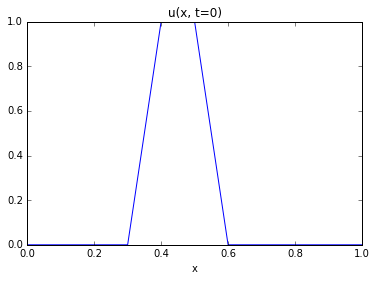

In [11]:
x = np.linspace (0.0, L, M)  # Grid points (coordinates)
u_0 = gen_u_centered_impulse (M)
plot_u (x, u_0, t="t=0")

**Exercise.** Define a function to build the matrix $A$ given the number of grid points $m$.

In [12]:
def build_matrix (m):
    # @YOUSE: Build a sparse matrix A
    #A = ...
    A = sp.sparse.csr_matrix (sp.sparse.diags ([1, -2, 1], [-1, 0, 1], shape=(m, m)))
    A[0, 0] = -1
    A[m-1, m-1] = -1
    return A

print ("=== A (m=%d) ===\n" % M, build_matrix (M).toarray ())

('=== A (m=11) ===\n', array([[-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.]]))


**Exercise.** Write a function `f_diffusion()` to implement the ODE system's right hand side, $\vec{f}(t, \vec{u})$.

> The arguments to this function are the state vector $\vec{u}(t)$ at time $t$, the matrix $A$, diffusion coefficient $c$, and step size $\Delta x$.

In [36]:
def f_diffusion (u, t, A, c=C, dx=dx):
    assert type (u) is np.ndarray
    
    # @YOUSE: Compute `f[:]`
    #assert (False)
    f = c/(dx**2) * A.dot (u)

    assert type (f) is np.ndarray
    assert np.all (f.shape == u.shape)
    return f

In [37]:
def sim (c, m, t_max, verbose=True):
    dx = 1.0 / (m-1)
    u_0 = gen_u_centered_impulse (m)
    t_all = np.linspace (0.0, t_max, 3)
    
    A = build_matrix (m)
    U = odeint (f_diffusion, u_0, t_all, args=(A, c, dx))
    
    if verbose:
        print ("Time points:", t_all)
        print ("Peaks:", np.max (U, axis=1))
        print ("Sum of stuff:", np.sum (U, axis=1), "\n   ==> Is stuff conserved?")
    
    return (U, t_all)

L = 1.0
M = 101
dx = float (L) / (M-1)
C = dx

(U, t_all) = sim (c=C, m=M, t_max=1.0)

Time points: [ 0.   0.5  1. ]
Peaks: [ 1.          0.38303513  0.27637477]
Sum of stuff: [ 10.  10.  10.] 
   ==> Is stuff conserved?


Time points: [ 0.  0.  0.]
Peaks: [ 1.  1.  1.]
Sum of stuff: [ 10.  10.  10.] 
   ==> Is stuff conserved?


<function __main__.isim>

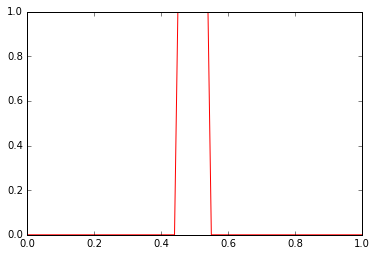

In [38]:
def isim (c=C, m=M, t_max=0.0):
    (U, t_all) = sim (c, m, t_max)
        
    x = np.linspace (0.0, 1.0, m)
    if t_max > 0.0:
        plt.plot (x, U[0, :], 'r', x, U[1, :], 'b', x, U[2, :], 'g')
    else:
        plt.plot (x, U[0, :], 'r')
        
# Initial conditions
from ipywidgets import interact

interact (isim
          , c=(0.01, 1.0, 0.01)
          , m=(11, 101, 10)
          , t_max=(0.0, 2.0, 0.01)
         )